#  Classification Problem for Occupancy Data Set
## Employing Deep Learning Techniques

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

import itertools

import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pprint import pprint

In [2]:
import keras
import sklearn
import tensorflow as tf

print(f"keras.__version__: {keras.__version__}")
print(f"sklearn.__version__: {sklearn.__version__}")
print(f"tf.__version__: {tf.__version__}")

keras.__version__: 2.4.3
sklearn.__version__: 0.23.1
tf.__version__: 2.2.0


In [34]:
from sklearn import set_config

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

In [4]:
os.getcwd()

'C:\\Users\\Francesco\\Documents\\machine-learning-analyses\\occupancy-detection-data-set\\dl\\classification-task'

In [5]:
from utils.build_models import build_model
from utils.cross_validation_train import k_fold_cv_classification
from utils.plot_util import show_cm, visualize_pca_reduced_data
from utils.train_util import wrapper_bench_k_means, create_and_run_pipeline, create_and_run_pipeline_GDCV, create_and_run_pipeline_GDCV_v2

### Global Variables

In [6]:
SEED = 1234
RANDOM_STATE = 42

K = 3 # Number of folds
BATCH_SIZE = 2
NUM_EPOCHS = 10

N_COMPONENTS = 2

target_names = ['Occupancy', 'Non-Occupancy']

np.random.seed(seed = SEED)

### Fetch Data: Training Set

In [7]:
dir_path = "C:\\Users\\Francesco\\Documents\\datasets\\occupancy_data"
file_name = "datatraining.txt"

file_path = os.path.join(dir_path, file_name)

print(file_path)

C:\Users\Francesco\Documents\datasets\occupancy_data\datatraining.txt


In [8]:
data = pd.read_csv(file_path)

In [9]:
data.describe(include="all")

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
unique,8143,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-09 00:42:59,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,NaN,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,NaN,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,NaN,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,NaN,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,NaN,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


### Fetch Data: Test Set

In [11]:
dir_path = "C:\\Users\\Francesco\\Documents\\datasets\\occupancy_data"
file_name = "datatest.txt"

file_path_test_set = os.path.join(dir_path, file_name)

print(file_path)

C:\Users\Francesco\Documents\datasets\occupancy_data\datatraining.txt


In [12]:
test_set_df = pd.read_csv(file_path_test_set)

In [13]:
test_set_df.describe(include="all")

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
unique,2665,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-02 21:04:59,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,NaN,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,NaN,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,NaN,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,NaN,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,NaN,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000


In [14]:
test_set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


## Preprocess Data Points: Normalize

In [15]:
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

X, y = shuffle(X, y, random_state=RANDOM_STATE)

### Test Pipeline

In [27]:
# Visualize the results on PCA-reduced data

# n_samples = 100
# reduced_data = PCA(n_components=2).fit_transform(X[0:n_samples,:])
# kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
# kmeans.fit(reduced_data)

# visualize_pca_reduced_data(kmeans, reduced_data, pc_1 = 0, pc_2 = 1)

In [28]:
x_test = test_set_df.iloc[:, 1:-1].values
y_test = test_set_df.iloc[:, -1].values

In [29]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
x_test_scaled = scaler.transform(x_test)

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(0.0001, 0.31622776601683794)

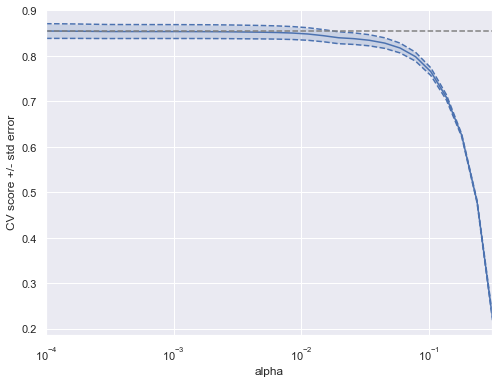

In [37]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=True)
clf.fit(X_scaled, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

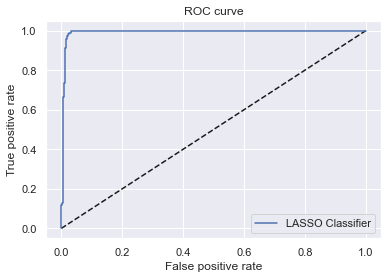

In [41]:
y_pred = clf.predict(x_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LASSO Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
n_features = X_scaled.shape[1]
print(f"# features: {n_features}")

In [ ]:
n_classes = len(np.unique(y))
print(f"# classes: {n_classes}")

In [ ]:
n_samples = X.shape[0]
print(f"# samples: {n_samples}")

In [ ]:
print("n_classes: %d, \t n_samples %d, \t n_features %d"
      % (n_classes, n_samples, n_features))

### K-fold CV Validation Protocol

In [ ]:
k_fold_cv_classification(
    train_data = X_scaled, train_targets = y,
    n_features = n_features,
    n_classes = n_classes,
    num_epochs = NUM_EPOCHS,
    k = K, batch_size = BATCH_SIZE,
    verbose = 0,
    num_units = 64, activation = 'relu', optimizer = 'rmsprop',
    show_plot = True, fig_size = (10, 5))

### Train opun overall Train set & evaluate on Test set

In [ ]:
model = build_model(n_features = n_features, n_classes = n_classes)

In [ ]:
model.fit(
    X_scaled, y,
    epochs = NUM_EPOCHS // 2,
    batch_size = BATCH_SIZE,
    verbose = 0
)

In [ ]:
results = model.evaluate(x_test_scaled, y_test)
pprint(results)

In [ ]:
y_pred = model.predict_classes(x_test_scaled)
# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
show_cm(y_test, y_pred, target_names, title = 'Confusion Matrix - Occupancy Dataset')

In [ ]:
pprint(classification_report(y_test, y_pred, target_names = target_names))

## Preprocess Data by means of PCA unsupervised approach

In [ ]:
pca = PCA(n_components=N_COMPONENTS)

pca = pca.fit(X)
X_pca = pca.transform(X)
x_test_pca = pca.transform(x_test)

In [ ]:
plt.figure()
plt.bar(range(1,len(pca.explained_variance_ )+1), pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

In [ ]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### K-fold CV Validation Protocol

In [ ]:
k_fold_cv_classification(
    train_data = X_pca, train_targets = y,
    n_features = N_COMPONENTS,
    n_classes = n_classes,
    num_epochs = NUM_EPOCHS,
    k = K, batch_size = BATCH_SIZE,
    verbose = 0,
    num_units = 64, activation = 'relu', optimizer = 'rmsprop',
    show_plot = True, fig_size = (10, 5))

### Train opun overall Train set & evaluate on Test set

In [ ]:
model = build_model(n_features = N_COMPONENTS, n_classes = n_classes)

In [ ]:
model.fit(
    X_pca, y,
    epochs = NUM_EPOCHS // 2,
    batch_size = BATCH_SIZE,
    verbose = 0
)

In [ ]:
results = model.evaluate(x_test_pca, y_test)
pprint(results)

In [ ]:
y_pred = model.predict_classes(x_test_pca)
# matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
show_cm(y_test, y_pred, target_names, n_classes = n_classes, title = 'Confusion Matrix - Occupancy Dataset')

In [ ]:
pprint(classification_report(y_test, y_pred, target_names = target_names))

### References

- (Logistic Regression with Keras) https://aigeekprogrammer.com/binary-classification-using-logistic-regression-and-keras/
- (panda-ml) https://pandas-ml.readthedocs.io/en/latest/index.html

### Tutorials
- (K-means) https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
- (Column Transformer with Mixed Types) https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
- (Feature transformations with ensembles of trees) https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py